In [1]:
#%%
# Core libraries
import os
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=50, facecolor="white")


import pooch

# adata = sc.read_10x_h5('/.mounts/labs/reimandlab/private/users/k2zhang/TIA18674.20211202/Ai_10xG_library/Ai_10xG_library.filtered_feature_bc_matrix.h5')

# Define the path to your data directory
data_dir = '/.mounts/labs/reimandlab/private/users/k2zhang/TIA18674.20211202/Ai_10xG_library/'

# Define the sample files
samples = {
    "1st_spheroid_co_cultrue": "Ai_10xG_library.filtered_feature_bc_matrix.h5",
    # Add more samples as needed
}

# Initialize a dictionary to store AnnData objects
adatas = {}

# Load each sample into an AnnData object and store in the dictionary
for sample_id, filename in samples.items():
    path = os.path.join(data_dir, filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

# Concatenate all the AnnData objects
adata = ad.concat(adatas, label="sample")

# Ensure observation names are unique
adata.obs_names_make_unique()

# Print the count of observations per sample
print(adata.obs["sample"].value_counts())
adata


/.mounts/labs/reimandlab/private/users/k2zhang/miniconda3/envs/cpdb/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
1st_spheroid_co_cultrue    8331
Name: count, dtype: int64


/.mounts/labs/reimandlab/private/users/k2zhang/miniconda3/envs/cpdb/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 8331 × 36602
    obs: 'sample'

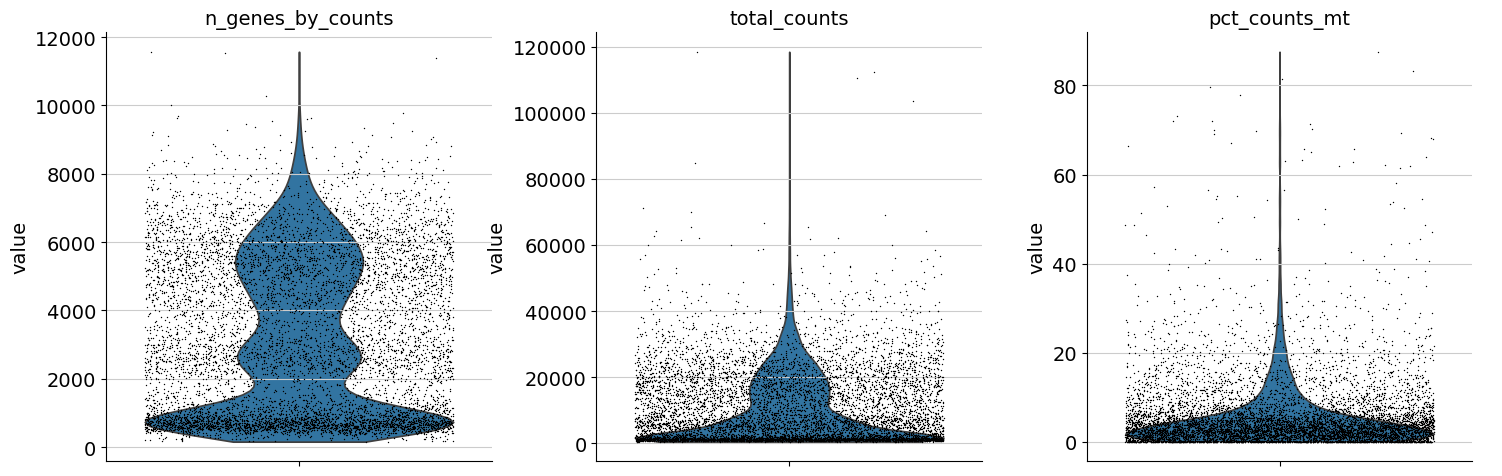

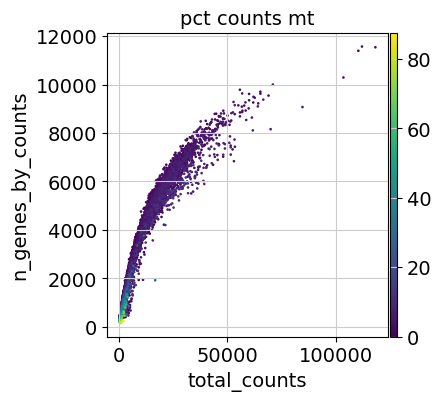

In [2]:

#%%
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

"""
Violin plots of some of the computed QC metrics:
- number of genes expressed in the count matrix
- total counts per cell
- percentage of counts in mitochondrial genes
"""

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# scatter plot 
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

# Doublet Score
sc.pp.scrublet(adata, batch_key="sample")

# Doublet Finder 

In [3]:

adata.obs["predicted_doublet"]

AAACCCACATCAGTGT-1    False
AAACCCACATGACTAC-1    False
AAACCCACATGTTACG-1    False
AAACCCAGTACACGCC-1    False
AAACCCAGTAGACAGC-1    False
                      ...  
TTTGTTGCAACTTGCA-1    False
TTTGTTGCATGGGATG-1    False
TTTGTTGGTCATCACA-1    False
TTTGTTGGTTTCACAG-1    False
TTTGTTGTCCTTGACC-1    False
Name: predicted_doublet, Length: 8331, dtype: bool

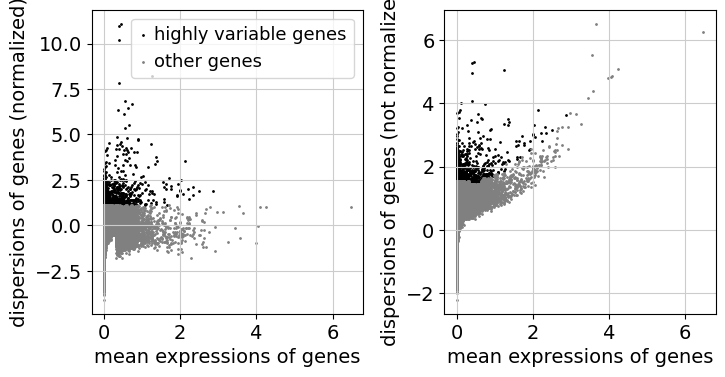

In [4]:
#%%
# Normalization

# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

# %%

# Feature Selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

sc.pl.highly_variable_genes(adata)




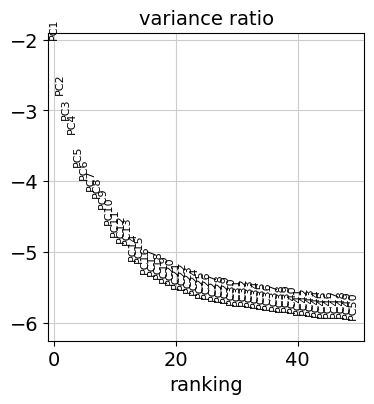

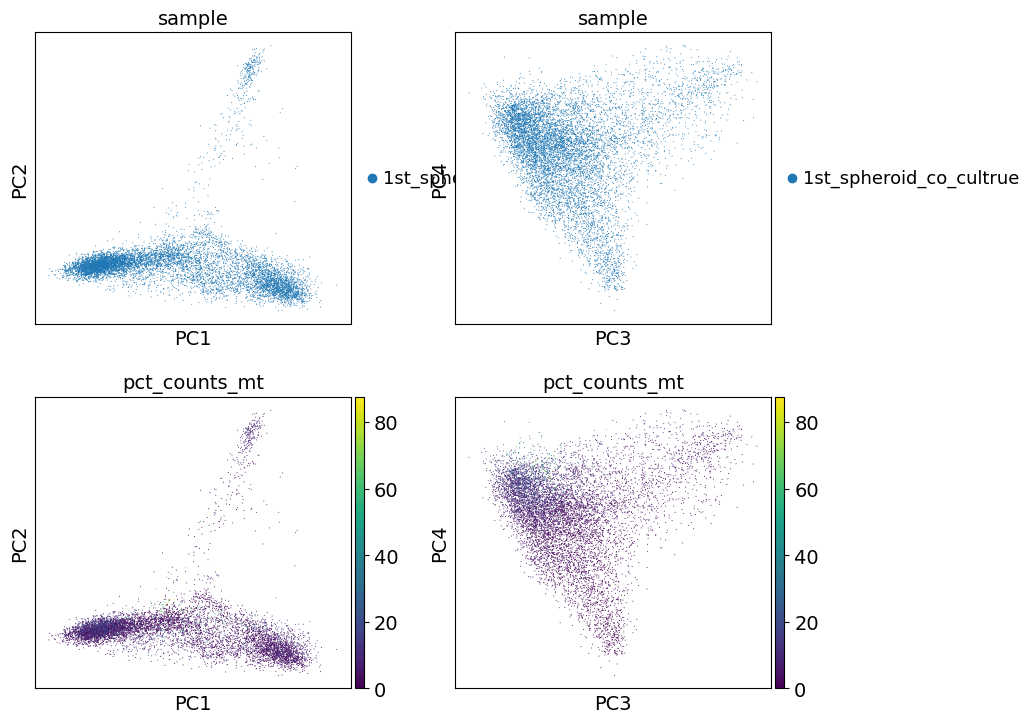

In [5]:
# %%

# PCA / Dimentionality Reduction
sc.tl.pca(adata)

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

# principal components
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)


/.mounts/labs/reimandlab/private/users/k2zhang/miniconda3/envs/cpdb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


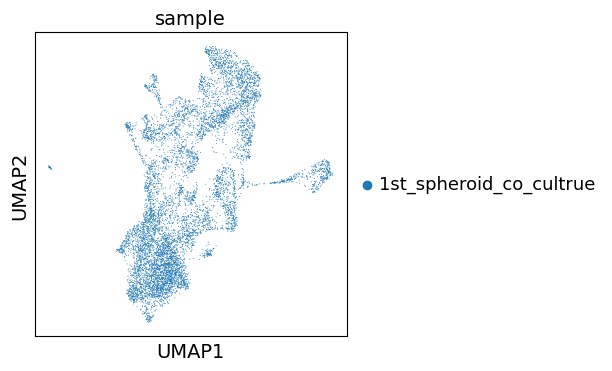

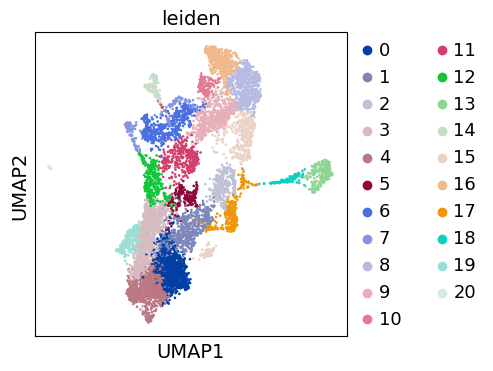

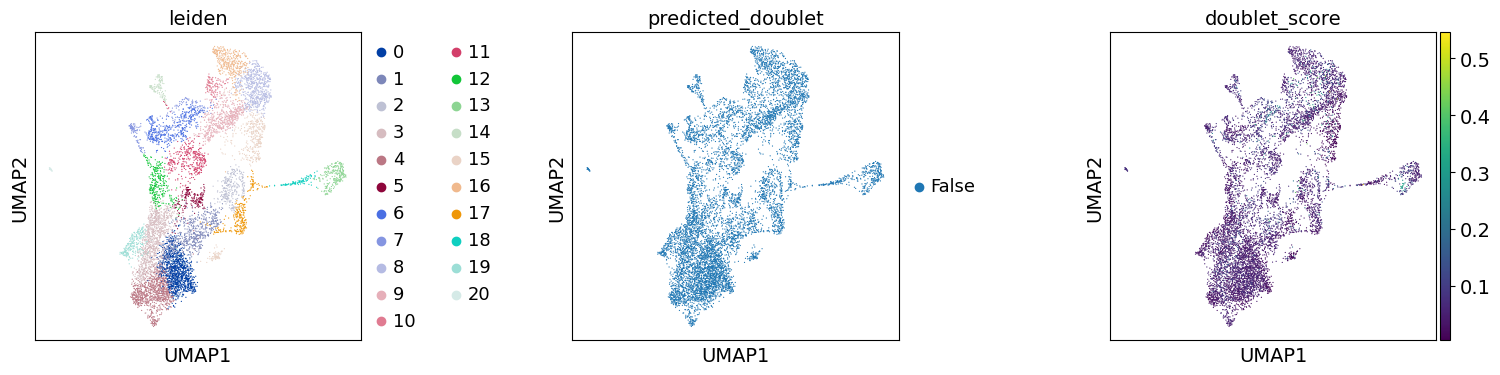

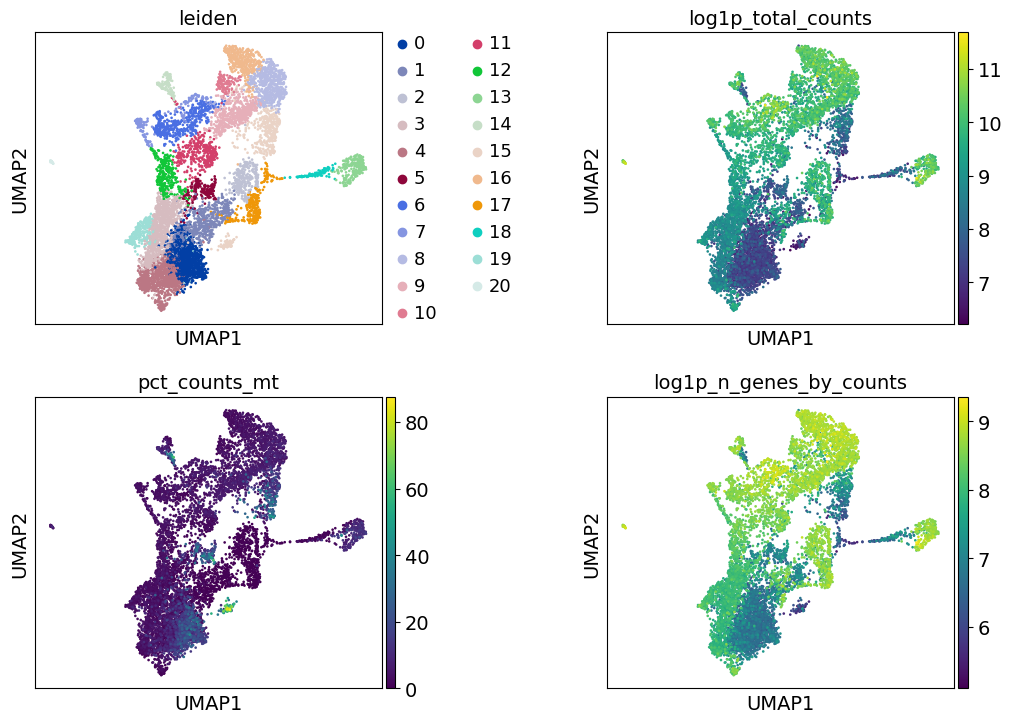

In [6]:
# %%

# Nearest neighbor graph constuction and visualization
sc.pp.neighbors(adata)

sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)
# %%

#Clustering

# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

sc.pl.umap(adata, color=["leiden"])

# Re-assess quality
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)



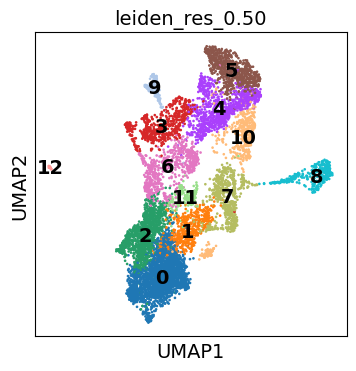

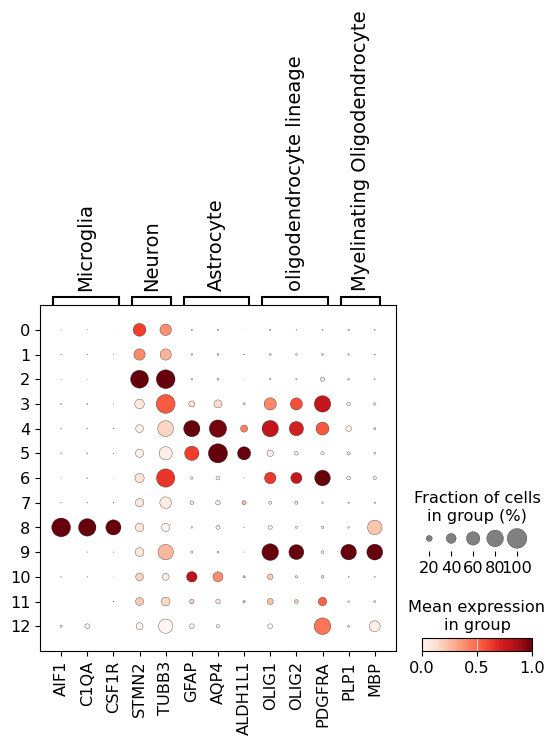

In [7]:
# %%

# Manual Cell Type Annotation
# generate a set of clustering solutions which we can then use to annotate our cell types
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

# sc.pl.umap(
#     adata,
#     color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
#     legend_loc="on data",
# )

sc.pl.umap(
    adata,
    color=["leiden_res_0.50"],
    legend_loc="on data",
)

#%%

# Marker gene set
marker_genes = {
    "Microglia": ["AIF1", "C1QA", "CSF1R"],
    "Neuron": ["STMN2", "TUBB3"],
    "Astrocyte": ["GFAP", "AQP4", "ALDH1L1"],
    "oligodendrocyte lineage": ["OLIG1", "OLIG2", "PDGFRA"],
    "Myelinating Oligodendrocyte": ["PLP1", "MBP"],
}

# sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

# adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_0.02"].map(
#     {
#         "0": "Microglia",
#         "1": "Neuron",
#         "2": "Astrocyte",
#         "3": "oligodendrocyte lineage",
#         "4": "Myelinating Oligodendrocyte",
#     }
# )

adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_0.50"].map(
    {
        "0": "Microglia",
        "1": "Neuron",
        "2": "Astrocyte",
        "3": "oligodendrocyte lineage",
        "4": "Myelinating Oligodendrocyte",
    }
)

sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")





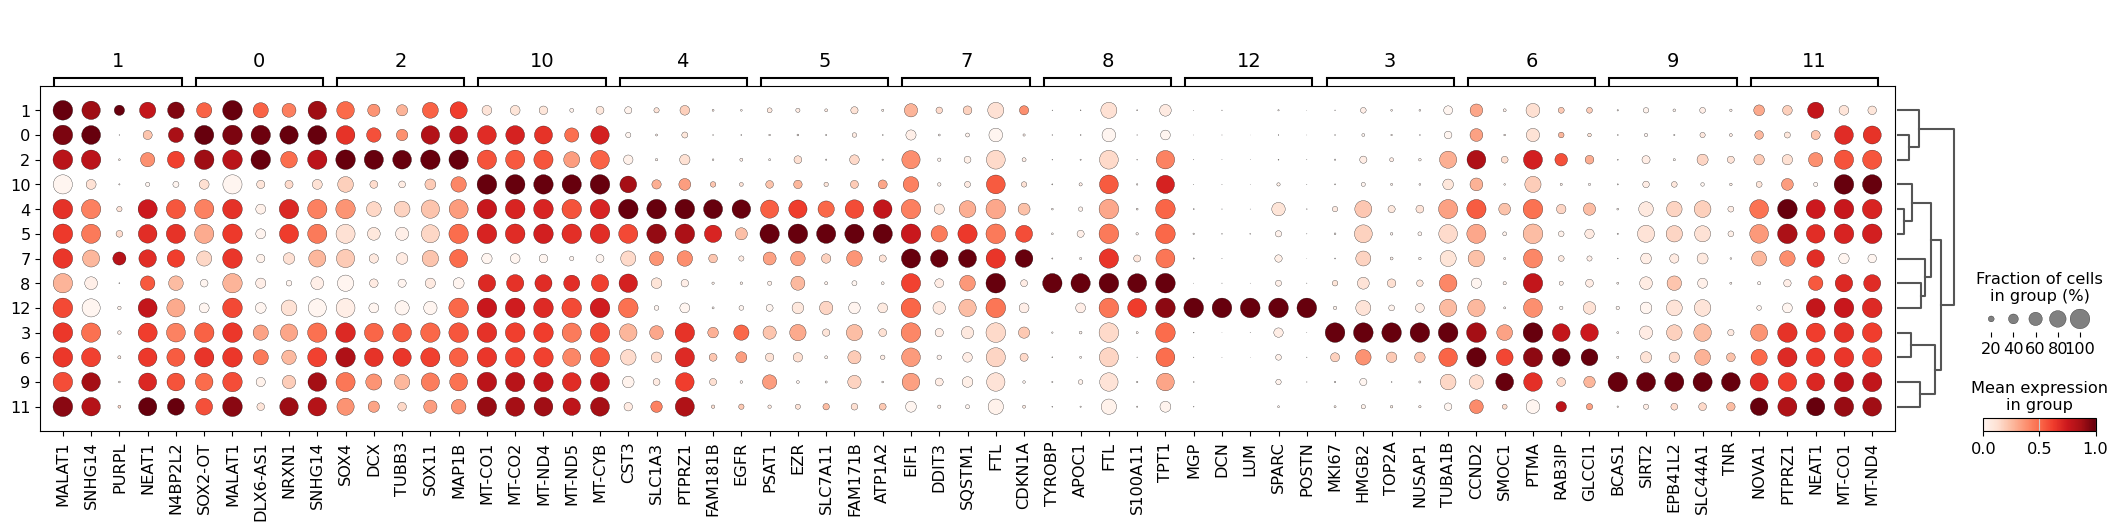

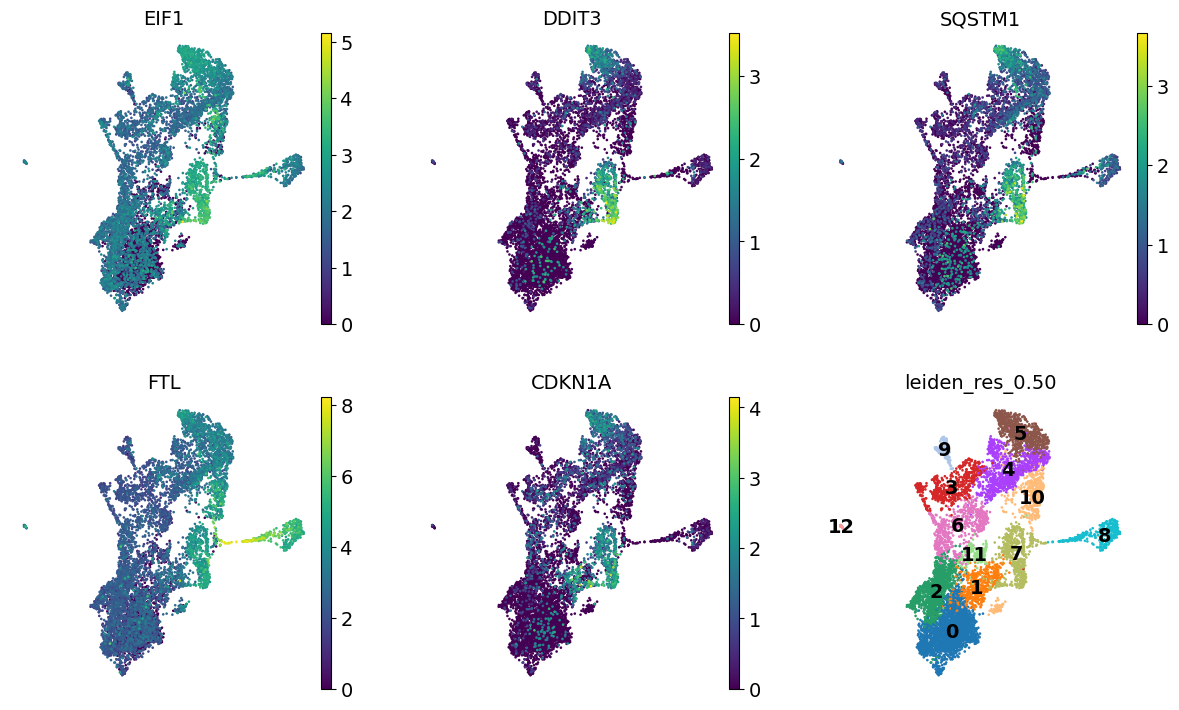

,names,scores,logfoldchanges,pvals,pvals_adj
0,EIF1,33.771729,2.558989,5.129971e-250,1.870461e-246
1,DDIT3,31.093552,4.378685,2.943885e-212,6.830617e-209
2,SQSTM1,30.375809,3.384783,1.146595e-202,2.438712e-199
3,FTL,30.016279,2.878702,6.017508e-198,1.181422e-194
4,CDKN1A,29.226076,3.464014,9.044864e-188,1.648943e-184


In [8]:
# %%

# Differentially-expressed Genes as Markers

# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.50", method="wilcoxon")

sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
)

sc.get.rank_genes_groups_df(adata, group="7").head(5)

dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="7").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

# %%

sc.get.rank_genes_groups_df(adata, group="7").head(5)


In [9]:
# Check Doublet score: 
# adata.obs["predicted_doublet"]

# use 0.5 resolution
# lable clear clusters


# For unclear clustres check neibours 
# Run Differentially-expressed Genes as Markers

# Put microglia and astrocyte in cpdb
# Test input




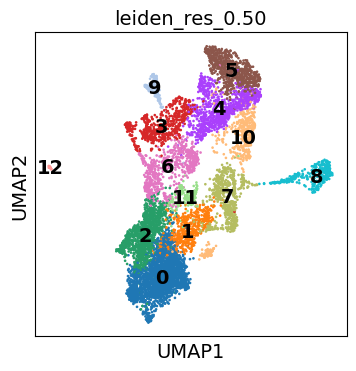

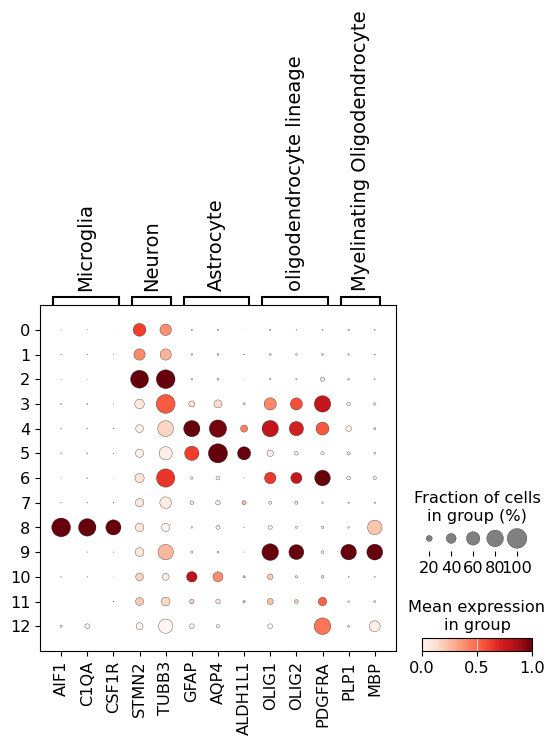

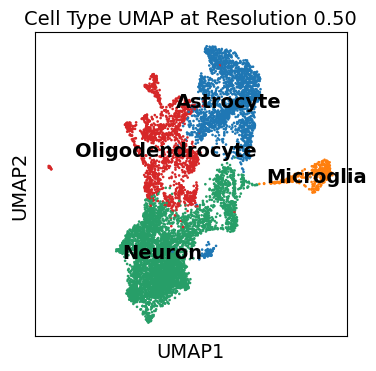

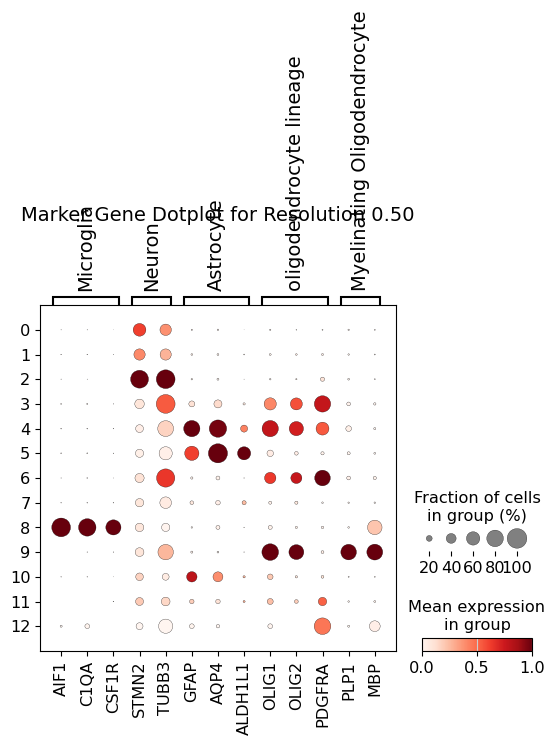

In [10]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.50"],
    legend_loc="on data",
)

sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

# Annotate cell types based on the leiden_res_0.50 clusters
adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_0.50"].map(
    {
        "0": "Neuron",
        "1": "Neuron",
        "2": "Neuron",
        "7": "Neuron", #? not sure
        "4": "Astrocyte",
        "5": "Astrocyte",
        "10": "Astrocyte", #not sure
        "8": "Microglia",
        "3": "Oligodendrocyte",
        "6": "Oligodendrocyte",
        "9": "Oligodendrocyte",
        "12": "Oligodendrocyte", #not sure
        "11": "Oligodendrocyte"
        #should be an 11 as well

        # Add more mappings if needed
    }
)

# Plot the UMAP with the cell type annotations
sc.pl.umap(adata, color=["cell_type_lvl1"], legend_loc="on data", title='Cell Type UMAP at Resolution 0.50')

# # Save the UMAP plot with cell type labels
# sc.pl.umap(adata, color=["cell_type_lvl1"], legend_loc="on data", save='_cell_type_umap_res_0.50_plot.png')

# Generate a dot plot for the marker genes
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var", title="Marker Gene Dotplot for Resolution 0.50")

# Save the updated AnnData object
adata.write('processed_adata_final.h5ad')


In [11]:
import pandas as pd

# Extract barcodes and cell types
meta_df = adata.obs[['cell_type_lvl1']].copy()
meta_df.reset_index(inplace=True)
meta_df.columns = ['barcode', 'cell_type']

# Save the meta file as TSV
meta_df.to_csv('meta_file.tsv', sep='\t', index=False)




In [12]:
# Extract the raw counts matrix
counts_df = adata.to_df(layer=None)

# Transpose the counts matrix
counts_df = counts_df.T

# Save the counts file as TSV
counts_df.to_csv('counts_file.tsv', sep='\t')



In [13]:
counts_df.head(10)

,AAACCCACATCAGTGT-1,AAACCCACATGACTAC-1,AAACCCACATGTTACG-1,AAACCCAGTACACGCC-1,AAACCCAGTAGACAGC-1,AAACCCAGTCAGGTAG-1,AAACCCAGTCCTACAA-1,AAACCCAGTTCATCGA-1,AAACCCATCAAGCCCG-1,AAACCCATCAGCCCAG-1,...,TTTGTTGAGGAGGCAG-1,TTTGTTGAGTGAGGCT-1,TTTGTTGAGTGCTAGG-1,TTTGTTGAGTTTCAGC-1,TTTGTTGCAAACACGG-1,TTTGTTGCAACTTGCA-1,TTTGTTGCATGGGATG-1,TTTGTTGGTCATCACA-1,TTTGTTGGTTTCACAG-1,TTTGTTGTCCTTGACC-1
AL627309.1,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.317906,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
AL627309.3,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
AL627309.5,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.311544,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
AL669831.2,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
LINC01409,0.0,0.0,0.626398,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.154824,...,0.0,0.0,0.458249,0.0,0.0,0.0,0.000000,0.0,0.0,0.351015
FAM87B,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
LINC01128,0.0,0.0,0.000000,0.33742,0.0,0.0,0.0,0.000000,0.000000,0.154824,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.262532,0.0,0.0,0.351015
LINC00115,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
FAM41C,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
AL645608.6,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.458249,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
